In [19]:
import gpflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
from sklearn.model_selection import train_test_split

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [17]:
tsla = pd.read_csv('TSLA.csv')
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


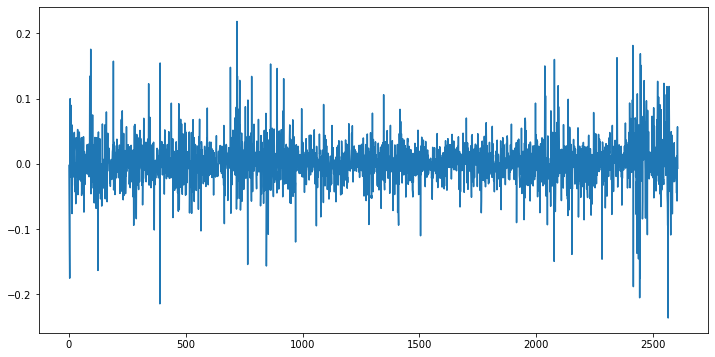

In [8]:
log_returns = np.log(tsla['Close'].values[1:] / tsla['Close'].values[:-1])
plt.plot(log_returns)

In [28]:
X = []
y = []

# trying to make a prediction on today's return based on the previous 30 days
for i in range(30, len(log_returns)):
    X.append(log_returns[i-30:i])
    y.append(log_returns[i])

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(2577, 30) (2577,)


In [21]:
k = gpflow.kernels.Matern52()
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern52.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern52.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [22]:
# mean is roughly 0, which is deafult for GPflow
# we can define a mean as a liear trend in the data with gpflow.mean_functions
np.mean(log_returns)

0.0017178992343082403

In [32]:
# split between train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=1)

print(X_train.shape, X_test.shape)

(2061, 30) (516, 30)


In [36]:
model = gpflow.models.GPR(data=(X_train, y_train), kernel=k, mean_function=None)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [39]:
# select an optimiser
optimizer = gpflow.optimizers.Scipy()

In [41]:
# in my pc 5 iterations take about a minute
opt_logs = optimizer.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=5))
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    0.0012831 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 8373.57      │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    1e-06     │
╘═════════════════════════╧═══════════╧═════════════════

In [44]:
# generate predictions on test set
mean, var = model.predict_f(X_test)

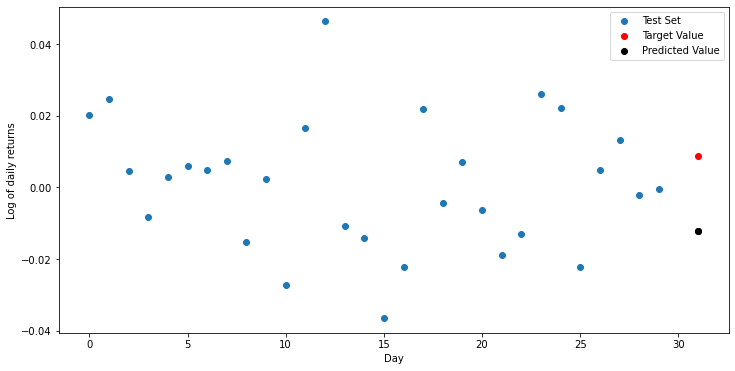

In [64]:
# plot a given sample with index j
j = 5

plt.scatter(np.arange(0, X_test[j, :].size), X_test[j, :], label='Test Set')
plt.scatter(X_test[j, :].size+1, y_test[j], color='red', label='Target Value')
plt.scatter(X_test[j, :].size+1, mean[j, 0] + 1.96 * np.sqrt(var[j, 0]), color='black', label='Predicted Value')
plt.scatter(X_test[j, :].size+1, mean[j, 0] - 1.96 * np.sqrt(var[j, 0]), color='black')

plt.xlabel('Day')
plt.ylabel('Log of daily returns')
plt.legend()